======== Baseline Measurement (Optimized Flags) ========
Result: 9227465
Execution Time (C code): 0.028576 seconds

Result: 9227465
Execution Time (C code): 0.028312 seconds

Result: 9227465
Execution Time (C code): 0.028285 seconds


======== Artificial Regression Measurement (Lower Opt) ========
Result: 9227465
Execution Time (C code): 0.050456 seconds

Result: 9227465
Execution Time (C code): 0.050732 seconds

Result: 9227465
Execution Time (C code): 0.050798 seconds

Compile time changed from avg 0.0953s to 0.0869s.
Run time changed from avg 0.2211s to 0.2622s.



/var/folders/p6/lz9nv0md22z21j6w4rb19b380000gp/T/ipykernel_22669/2581070877.py:224: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True, errors='coerce')


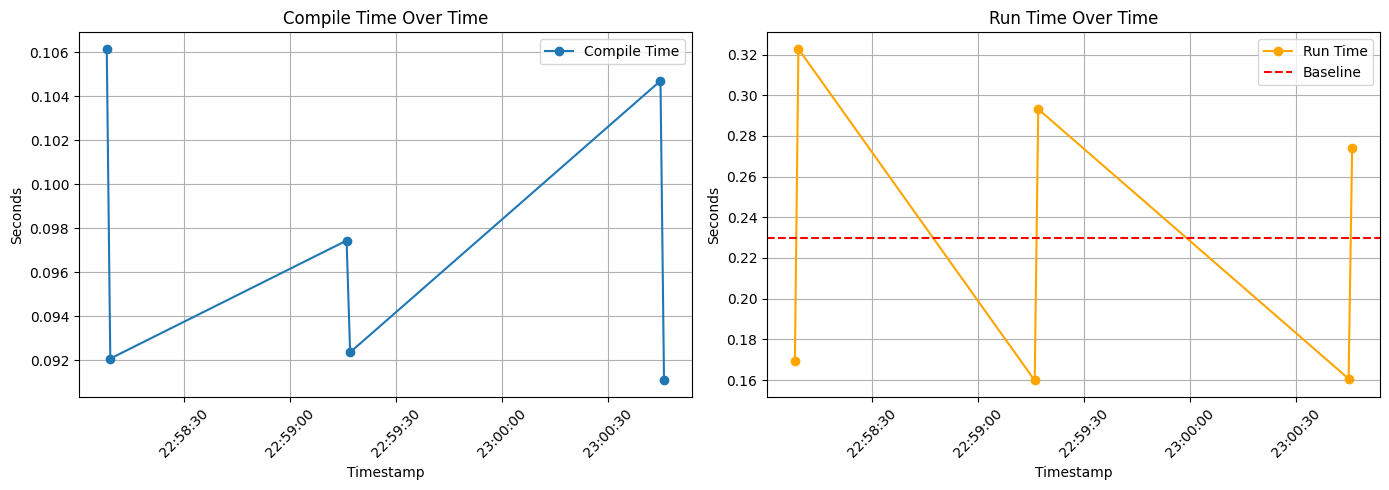

In [ ]:
# -----------------------------------
# Performance Regression Detection Tool
# Author: Muzammil Mahmud
# -----------------------------------
# For demonstration: We'll use a small C code snippet to measure performance.


import subprocess
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# i2i --> 0xDEADBEEF, 4, 8, 15, 16, 23, 42
# "Those who know do not speak. Those who speak do not know." 


# =========================================================================================
# 1. Configuration Section
# =========================================================================================

# Path to the C compiler (modify if not in PATH)
COMPILER = "clang"  # or "gcc"

# Name of the test C file
TEST_C_FILE = "fibonacci.c"

# Flags for baseline compilation (e.g., optimized)
BASELINE_FLAGS = ["-O2"]

# Flags for artificial regression (e.g., lower optimization)
REGRESSION_FLAGS = ["-O0"]

# Output binary name
OUTPUT_BINARY = "fib_test"

# Baseline CSV file (stores historical performance data)
BASELINE_CSV = "baseline_performance.csv"

# Threshold for performance regression in seconds (or ratio)
REGRESSION_THRESHOLD_RATIO = 0.05  # e.g., > 5% slower than baseline is flagged

# Number of runs for each test to average results
NUM_RUNS = 3


# =========================================================================================
# 2. Benchmark Program Creation (if not already present)
# =========================================================================================
# We'll create a small fibonacci C program for demonstration.
# In a real scenario, you'd replace or extend this with your actual benchmark suite.

fibonacci_code = r'''
#include <stdio.h>
#include <time.h>

// Simple fibonacci function (inefficient recursion for demonstration)
long long fib(long long n) {
    if(n < 2) return n;
    return fib(n - 1) + fib(n - 2);
}

int main() {
    // We'll measure time inside the program as well,
    // though you can also measure outside in Python.
    clock_t start = clock();
    // Calculate a moderately large fibonacci number
    long long result = fib(35);
    clock_t end = clock();

    double time_spent = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Result: %lld\n", result);
    printf("Execution Time (C code): %f seconds\n", time_spent);

    return 0;
}
'''

# If the file doesn't exist, create it
if not os.path.exists(TEST_C_FILE):
    with open(TEST_C_FILE, 'w') as f:
        f.write(fibonacci_code)


# =========================================================================================
# 3. Functions to Compile and Run Benchmarks
# =========================================================================================

def compile_program(compiler, flags, source_file, output_file):
    """
    Compiles the source_file with the given compiler and flags,
    produces the output_file (binary).
    Returns the compilation time in seconds.
    """
    start_time = time.time()
    cmd = [compiler] + flags + [source_file, "-o", output_file]
    # Example: clang -O2 fibonacci.c -o fib_test
    subprocess.run(cmd, check=True)
    end_time = time.time()
    compilation_time = end_time - start_time
    return compilation_time

def run_program(output_file):
    """
    Runs the compiled binary and measures total elapsed time.
    Also captures the program's stdout for analysis if needed.
    Returns the execution time in seconds.
    """
    start_time = time.time()
    result = subprocess.run(["./" + output_file], capture_output=True, text=True, check=True)
    end_time = time.time()
    run_time = end_time - start_time
    
    # Optional: Print or parse the console output
    # For instance, parse the "Execution Time (C code):" line if needed
    # For this example, we simply show it:
    print(result.stdout)

    return run_time


# =========================================================================================
# 4. Baseline Data Handling
# =========================================================================================

def load_baseline_data(baseline_csv):
    """
    Loads the existing baseline data from CSV.
    If file doesn't exist, returns an empty DataFrame.
    """
    if os.path.exists(baseline_csv):
        return pd.read_csv(baseline_csv)
    else:
        return pd.DataFrame(columns=["timestamp", 
                                     "compile_time", 
                                     "run_time", 
                                     "flags"])


def save_baseline_data(df, baseline_csv):
    """
    Saves the DataFrame to CSV.
    """
    df.to_csv(baseline_csv, index=False)


# =========================================================================================
# 5. Main Routine: Perform Baseline & Regression Test
# =========================================================================================

def measure_performance(compiler, flags):
    """
    Compile + run the program multiple times (to reduce variance).
    Return average compile_time and run_time.
    """
    compile_times = []
    run_times = []

    for _ in range(NUM_RUNS):
        ctime = compile_program(compiler, flags, TEST_C_FILE, OUTPUT_BINARY)
        rtime = run_program(OUTPUT_BINARY)
        compile_times.append(ctime)
        run_times.append(rtime)
    
    avg_compile_time = sum(compile_times) / len(compile_times)
    avg_run_time = sum(run_times) / len(run_times)
    return avg_compile_time, avg_run_time

def record_performance(compile_time, run_time, flags):
    """
    Records performance data into the baseline CSV and groups multiple runs by timestamp.
    """
    baseline_df = load_baseline_data(BASELINE_CSV)

    # Create a new DataFrame for the new entry
    new_entry = pd.DataFrame([{
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "compile_time": compile_time,
        "run_time": run_time,
        "flags": " ".join(flags)
    }])

    # Concatenate the new entry with the existing baseline DataFrame
    baseline_df = pd.concat([baseline_df, new_entry], ignore_index=True)

    # Separate numeric and non-numeric columns
    numeric_columns = ['compile_time', 'run_time']
    non_numeric_columns = ['flags']

    # Group by timestamp and calculate the mean for numeric columns
    numeric_grouped = baseline_df.groupby('timestamp')[numeric_columns].mean().reset_index()

    # Take the first occurrence of non-numeric columns
    non_numeric_grouped = baseline_df.groupby('timestamp')[non_numeric_columns].first().reset_index()

    # Merge the numeric and non-numeric DataFrames (without duplicating the 'timestamp' column)
    grouped_df = pd.merge(numeric_grouped, non_numeric_grouped, on='timestamp')

    # Save the updated DataFrame
    save_baseline_data(grouped_df, BASELINE_CSV)
    return grouped_df



# =========================================================================================
# 6. Reporting & Visualization
# =========================================================================================

import matplotlib.dates as mdates

def plot_performance_history():
    """
    Plots the performance history from the baseline CSV file
    showing compile_time and run_time over time.
    """
    df = load_baseline_data(BASELINE_CSV)
    if df.empty:
        print("No data to plot.")
        return

    # Convert timestamps to datetime, allowing for mixed formats
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True, errors='coerce')

    # Drop any rows with invalid timestamps
    df = df.dropna(subset=['timestamp'])

    # Calculate baseline (average of all run times)
    avg_run_time = df['run_time'].mean()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot compile times
    axes[0].plot(df['timestamp'], df['compile_time'], marker='o', label='Compile Time')
    axes[0].set_title('Compile Time Over Time')
    axes[0].set_xlabel('Timestamp')
    axes[0].set_ylabel('Seconds')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axes[0].tick_params(axis='x', rotation=45)

    # Plot run times
    axes[1].plot(df['timestamp'], df['run_time'], marker='o', color='orange', label='Run Time')
    axes[1].axhline(y=avg_run_time, color='red', linestyle='--', label='Baseline')
    axes[1].set_title('Run Time Over Time')
    axes[1].set_xlabel('Timestamp')
    axes[1].set_ylabel('Seconds')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()



# =========================================================================================
# 7. Regression Detection
# =========================================================================================

def detect_regression(new_compile_time, new_run_time, baseline_csv):
    """
    Checks if new performance metrics deviate from the historical average
    by more than the REGRESSION_THRESHOLD_RATIO. If so, alerts.
    """
    df = load_baseline_data(baseline_csv)
    if len(df) == 0:
        # No baseline data to compare
        return False, "No baseline data exists yet."
    
    # We compute the average from the entire data. 
    # Alternatively, you might want a rolling average or last known good commit data.
    avg_compile_time = df['compile_time'].mean()
    avg_run_time = df['run_time'].mean()
    
    # Condition for regression
    compile_regression = (new_compile_time - avg_compile_time) / avg_compile_time > REGRESSION_THRESHOLD_RATIO
    run_regression = (new_run_time - avg_run_time) / avg_run_time > REGRESSION_THRESHOLD_RATIO
    
    if compile_regression or run_regression:
        msg = (
            "WARNING: Regression detected!\n"
            f"Compile time changed from avg {avg_compile_time:.4f}s to {new_compile_time:.4f}s.\n"
            f"Run time changed from avg {avg_run_time:.4f}s to {new_run_time:.4f}s.\n"
        )
        return True, msg
    else:
        msg = (
            f"No significant regression.\n"
            f"Compile time: {new_compile_time:.4f}s (avg {avg_compile_time:.4f}s)\n"
            f"Run time: {new_run_time:.4f}s (avg {avg_run_time:.4f}s)\n"
        )
        return False, msg


# =========================================================================================
# 8. Main Flow to Demonstrate the Full Pipeline
# =========================================================================================

def main_flow():
    """
    Runs the entire process:
    1) Measure baseline performance (O2).
    2) Record performance.
    3) Measure regression performance (O0).
    4) Compare results, detect regression.
    5) Plot the performance history.
    """
    print("======== Baseline Measurement (Optimized Flags) ========")
    baseline_compile_time, baseline_run_time = measure_performance(COMPILER, BASELINE_FLAGS)
    record_performance(baseline_compile_time, baseline_run_time, BASELINE_FLAGS)

    print("\n======== Artificial Regression Measurement (Lower Opt) ========")
    regression_compile_time, regression_run_time = measure_performance(COMPILER, REGRESSION_FLAGS)
    record_performance(regression_compile_time, regression_run_time, REGRESSION_FLAGS)

    # Detect regression
    regression_detected, message = detect_regression(regression_compile_time, regression_run_time, BASELINE_CSV)
    print(message)

    # Plot the performance history
    plot_performance_history()

# =========================================================================================
# Let's Run Everything!
# =========================================================================================
main_flow()